# Identifying Need for Change: North Carolina School Performance

Out of the 2,617 public schools (including Charter) operating in North Carolina during the 2016-2017 school year, 902 schools (34.5%) have, for at least one year since 2013-2014, been classified as a low performing school. 

NCPDI classifies low performing schools as:

“Low-performing schools are those that receive a **school performance grade** of **D** or **F** and a **school growth score** of **"met expected growth"** or **"not met expected growth"** as defined by G.S. 115C-83.15.” (G.S. 115C-105.37(a)), and

“A Low-performing local school administrative unit is a unit in which the majority of the schools in that unit that received a school performance grade and school growth score as provided in G.S. 115C-83.15 have been identified as low-performing schools, as provided in G.S. 115C-105.37.” (G.S. 115C-105.39A(a)).

Source: http://www.ncpublicschools.org/schooltransformation/low-performing/

**Thus, we treat low performing schools as a proxy for aggregate student educational achievement.**


## Problem Statement: 
In recent years, 30% of public schools in North Carolina have been low performing. Students in low performing schools are not meeting the educational achievement standards set by the state. Factors outside administrators' control: economically disadvantaged and majority-minority student populations, are the most influential indicators of low performance.  


## Motivation: 
Of the 902 schools low performing between 2013/14 and 2016/17, 209 have been low performing for all schools years (8%), 203 have been low performing for 3 of the schools years (7.8%), 227 have been low performing for 2 schools years (8.7%), and 263 have been low performing once (10%). Another way to look at these numbers is to consider that out of the four school years between 2013/14 and 2016/2017, 24.4% of schools have been recurringly low performing. 

What does this mean in terms of students? 
Out of around the 1.5 million total number of students studying in a public school in the 2016/17 school year, around 460,000 of those students (30%) have had at least a year studying a low performing school. Around 100,000 students (6.8%) in North Carolina study at a school that has been low performing for 4 years. 


## Solution:
We identify the factors within school administrator's control that can positively impact a school's EVAAS growth score. Growth scores are a metric to measure how well a school's performance increases over a year. We focus on growth instead of raw performance scores, as raw scores will be much slower to change over time. 

This notebook reviews NCPDI North Carolina School Report Card and Statistical Profile data to identify the factors that contribute to low school performance and EVAAS growth scores. We will then create a model to predict EVAAS growth scores including only school-level factors irrespective of student demographics. After determining the most predictive factors for determining EVAAS growth scores, we simulate changes in these factors to demonstrate a theoretical improvement in student achievement growth. 

We: 
1. Take a look at the heuristically most common reasons for low school performance: percentage of economically disadvantaged students, student demographics, and school funding to see if these indicators are statistically different in low performing schools. 

2. Remove the factors outside of the school adminsitration's control from the dataset to determine which school-level factors are most important in determining low performance by:
    1. Performing Feature Importance using XGBoost. XGBoost is a tree-based gradient-boosting method which minimizes a cost function relative to predicting a target variable. When a node in a decision tree is split, we can calculate the following reduction in impurity, and attribute this reduction to feature involved. When the tree is finished splitting nodes, those features with the largest proportional contribution toward decreasing impurity within nodes can be said to be the most “important.”
    
4. **Test the predictive nature of our selected features by creating a classification model to predict the EVAAS growth score for each of our 4 years. Whether these features are important will be reflected in the accuracy and precision of the regression model. **

5. Use a new methodology for decision-making. We create a function that will synthesize data based on percent changes in a certain input feature to then be used in our regression model to predict low performance. This will allow us to review, all things being equal, how a change in one or more features may correlate to a change in school EVAAS growth score. 


*Please note: Dataset Creation and Processing can be found: https://github.com/oleeson/NCPDI-Capstone*

In [1]:
#import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

#Change Dir to Import Dataset for EDA 
os.chdir("..")
cwd = os.getcwd()
inPath = cwd + "/DatasetCreation"
outPath = cwd + "/Visuals"

In [2]:
## Read in Schools Dataset
df_14 = pd.read_csv(inPath+'/2014/PublicSchools2014_LPS_Processed.csv')
df_15 = pd.read_csv(inPath+'/2015/PublicSchools2015_LPS_Processed.csv')
df_16 = pd.read_csv(inPath+'/2016/PublicSchools2016_LPS_Processed.csv')
df_17 = pd.read_csv(inPath+'/2017/PublicSchools2017_LPS_Processed.csv')

print(df_14.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 141 entries, closed_ind to unit_code
dtypes: float64(105), int64(36)
memory usage: 2.6 MB
None


In [3]:
print(df_14['unit_code'][df_14['SPG Score'] == 0].count())
print(df_15['unit_code'][df_15['SPG Score'] == 0].count())
print(df_16['unit_code'][df_16['SPG Score'] == 0].count())
print(df_17['unit_code'][df_17['SPG Score'] == 0].count())

df_14 = df_14[df_14['SPG Score'] != 0]
df_15 = df_15[df_15['SPG Score'] != 0]
df_16 = df_16[df_16['SPG Score'] != 0]
df_17 = df_17[df_17['SPG Score'] != 0]

print (df_14.info())
print (df_15.info())
print (df_16.info())
print (df_17.info())

128
130
128
130
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298 entries, 0 to 2425
Columns: 141 entries, closed_ind to unit_code
dtypes: float64(105), int64(36)
memory usage: 2.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 0 to 2431
Columns: 184 entries, closed_ind to unit_code
dtypes: float64(115), int64(69)
memory usage: 3.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 0 to 2429
Columns: 171 entries, closed_ind to unit_code
dtypes: float64(121), int64(50)
memory usage: 3.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 0 to 2442
Columns: 165 entries, title1_type_cd to unit_code
dtypes: float64(112), int64(53)
memory usage: 2.9 MB
None


In [4]:
#Create Column Subsets
#Calendar type removed
profileCols = ['title1_type_cd',
 'clp_ind',
 'focus_clp_ind',
 'summer_program_ind',
 'student_num',
 'lea_avg_student_num',
 'Grad_project_status',
 'category_cd_E',
 'category_cd_H',
 'category_cd_I',
 'category_cd_M',
 'category_cd_T',
 'esea_status_Esea_Pass',
 'esea_status_Non_Esea',
 'SBE Region_Northeast',
 'SBE Region_Northwest',
 'SBE Region_Piedmont-Triad',
 'SBE Region_Sandhills',
 'SBE Region_Southeast',
 'SBE Region_Southwest',
 'SBE Region_Western']

demographicCols = ['AsianFemalePct',
 'AsianMalePct',
 'AsianPct',
 'BlackFemalePct',
 'BlackMalePct',
 'BlackPct',
 'HispanicFemalePct',
 'HispanicMalePct',
 'HispanicPct',
 'IndianFemalePct',
 'IndianMalePct',
 'IndianPct',
 'MinorityFemalePct',
 'MinorityMalePct',
 'MinorityPct',
 'PacificIslandFemalePct',
 'PacificIslandMalePct',
 'PacificIslandPct',
 'TwoOrMoreFemalePct',
 'TwoOrMoreMalePct',
 'TwoOrMorePct',
 'WhiteFemalePct',
 'WhiteMalePct',
 'WhitePct',
 'pct_eds']

environmentCols = ['avg_daily_attend_pct',
 'crime_per_c_num',
 'short_susp_per_c_num',
 'long_susp_per_c_num',
 'expelled_per_c_num',
 'stud_internet_comp_num',
 'lea_avg_daily_attend_pct',
 'lea_crime_per_c_num',
 'lea_short_susp_per_c_num',
 'lea_long_susp_per_c_num',
 'lea_expelled_per_c_num',
 'lea_stud_internet_comp_num',
 'digital_media_pct',
 'avg_age_media_collection',
 'books_per_student',
 'lea_avg_age_media_collection',
 'lea_books_per_student',
 'wap_num',
 'wap_per_classroom',
 'lea_wap_num',
 'lea_wap_per_classroom',
 'Byod_Yes',
 '_1_to_1_access_Yes',
 'SRC_devices_sent_home_Yes']

educatorCols = ['flicensed_teach_pct',
 'tchyrs_0thru3_pct',
 'tchyrs_4thru10_pct',
 'tchyrs_11plus_pct',
 'class_teach_num',
 'nbpts_num',
 'advance_dgr_pct',
 '_1yr_tchr_trnovr_pct',
 'lea_flicensed_teach_pct',
 'lea_tchyrs_0thru3_pct',
 'lea_tchyrs_4thru10_pct',
 'lea_tchyrs_11plus_pct',
 'lea_class_teach_num',
 'lea_nbpts_num',
 'lea_advance_dgr_pct',
 'lea_1yr_tchr_trnovr_pct',
 'lea_lateral_teach_pct',
 '0-3 Years_LEA_Exp_Pct_Prin',
 '10+ Years_LEA_Exp_Pct_Prin',
 '4-10 Years_LEA_Exp_Pct_Prin',
 'Accomplished_TCHR_Standard 1_Pct',
 'Accomplished_TCHR_Standard 2_Pct',
 'Accomplished_TCHR_Standard 3_Pct',
 'Accomplished_TCHR_Standard 4_Pct',
 'Accomplished_TCHR_Standard 5_Pct',
 'Developing_TCHR_Standard 1_Pct',
 'Developing_TCHR_Standard 2_Pct',
 'Developing_TCHR_Standard 3_Pct',
 'Developing_TCHR_Standard 4_Pct',
 'Developing_TCHR_Standard 5_Pct',
 'Distinguished_TCHR_Standard 1_Pct',
 'Distinguished_TCHR_Standard 2_Pct',
 'Distinguished_TCHR_Standard 3_Pct',
 'Distinguished_TCHR_Standard 4_Pct',
 'Distinguished_TCHR_Standard 5_Pct',
 'Not Demostrated_TCHR_Standard 1_Pct',
 'Not Demostrated_TCHR_Standard 2_Pct',
 'Not Demostrated_TCHR_Standard 3_Pct',
 'Not Demostrated_TCHR_Standard 4_Pct',
 'Not Demostrated_TCHR_Standard 5_Pct',
 'Proficient_TCHR_Standard 1_Pct',
 'Proficient_TCHR_Standard 2_Pct',
 'Proficient_TCHR_Standard 3_Pct',
 'Proficient_TCHR_Standard 4_Pct',
 'Proficient_TCHR_Standard 5_Pct']

fundingCols = ['lea_total_expense_num',
 'lea_salary_expense_pct',
 'lea_services_expense_pct',
 'lea_supplies_expense_pct',
 'lea_instruct_equip_exp_pct',
 'lea_federal_perpupil_num',
 'lea_local_perpupil_num',
 'lea_state_perpupil_num',]

performCols = [
 'SPG Score',
 'EVAAS Growth Score',
 'Overall Achievement Score',
 'TotalTargets_pTarget_PctMet',
 'lea_sat_avg_score_num',
 'lea_sat_participation_pct',
 'lea_ap_participation_pct',
 'lea_ap_pct_3_or_above',
 'Does Not Meet Expected Growth_TCHR_Student Growth_Pct',
 'Exceeds Expected Growth_TCHR_Student Growth_Pct',
 'Meets Expected Growth_TCHR_Student Growth_Pct',
 'LPS_14',
 'LPS_15',
 'LPS_16',
 'LPS_17',
 'RLPS',
 'SPG Grade_A+NG',
 'SPG Grade_B',
 'SPG Grade_C',
 'SPG Grade_D',
 'SPG Grade_F',
 'SPG Grade_I',
 'Reading SPG Grade_B',
 'Reading SPG Grade_C',
 'Reading SPG Grade_D',
 'Reading SPG Grade_F',
 'Math SPG Grade_B',
 'Math SPG Grade_C',
 'Math SPG Grade_D',
 'Math SPG Grade_F',
 'EVAAS Growth Status_Met',
 'EVAAS Growth Status_NotMet',
 'State Gap Compared_Y']

In [5]:
featureImportance = ['short_susp_per_c_num','avg_daily_attend_pct', 
                    'student_num', 'lea_wap_num', 'lea_avg_student_num', 
                    'tchyrs_0thru3_pct', 'nbpts_num', 'lea_crime_per_c_num', 
                    'lea_short_susp_per_c_num', 'stud_internet_comp_num', 
                    'class_teach_num', 'lea_class_teach_num', 'flicensed_teach_pct', 
                    '4-10 Years_LEA_Exp_Pct_Prin']

In [6]:
combined_cols = (environmentCols + educatorCols + profileCols)
all_cols = (environmentCols + fundingCols + educatorCols + profileCols + demographicCols)

In [7]:
len(combined_cols)

90

In [19]:
len(demographicCols)

25

In [8]:
combined_cols.append('SPG Score')
featureImportance.append('SPG Score')
all_cols.append('SPG Score')

In [9]:

df_sub_14 = df_14[df_14.columns.intersection(combined_cols)]
df_imp_14 = df_14[df_14.columns.intersection(featureImportance)]
df_all_14 = df_14[df_14.columns.intersection(all_cols)]

df_sub_15 = df_15[df_15.columns.intersection(combined_cols)]
df_imp_15 = df_15[df_15.columns.intersection(featureImportance)]
df_all_15 = df_15[df_15.columns.intersection(all_cols)]

df_sub_16 = df_16[df_16.columns.intersection(combined_cols)]
df_imp_16 = df_16[df_16.columns.intersection(featureImportance)]
df_all_16 = df_16[df_16.columns.intersection(all_cols)]

df_sub_17 = df_17[df_17.columns.intersection(combined_cols)]
df_imp_17 = df_17[df_17.columns.intersection(featureImportance)]
df_all_17 = df_17[df_17.columns.intersection(all_cols)]

In [10]:
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [11]:
## Combined Columns
subYears = {}

y_sub_14 = df_sub_14['SPG Score'].values
x_sub_14 = df_sub_14.drop('SPG Score', axis=1).values
subYears['2014'] = [x_sub_14, y_sub_14]

y_sub_15 = df_sub_15['SPG Score'].values
x_sub_15 = df_sub_15.drop('SPG Score', axis=1).values
subYears['2015'] = [x_sub_15, y_sub_15]

y_sub_16 = df_sub_16['SPG Score'].values
x_sub_16 = df_sub_16.drop('SPG Score', axis=1).values
subYears['2016'] = [x_sub_16, y_sub_16]

y_sub_17 = df_sub_17['SPG Score'].values
x_sub_17 = df_sub_17.drop('SPG Score', axis=1).values
subYears['2017'] = [x_sub_17, y_sub_17]

#print(subYears)

## Feature Importance
impYears = {}

y_imp_14 = df_imp_14['SPG Score'].values
x_imp_14 = df_imp_14.drop('SPG Score', axis=1).values
impYears['2014'] = [x_imp_14, y_imp_14]

y_imp_15 = df_imp_15['SPG Score'].values
x_imp_15 = df_imp_15.drop('SPG Score', axis=1).values
impYears['2015'] = [x_imp_15, y_imp_15]

y_imp_16 = df_imp_16['SPG Score'].values
x_imp_16 = df_imp_16.drop('SPG Score', axis=1).values
impYears['2016'] = [x_imp_16, y_imp_16]

y_imp_17 = df_imp_17['SPG Score'].values
x_imp_17 = df_imp_17.drop('SPG Score', axis=1).values
impYears['2017'] = [x_imp_17, y_imp_17]

## All Columns
allYears = {}

y_all_14 = df_all_14['SPG Score'].values
x_all_14 = df_all_14.drop('SPG Score', axis=1).values
allYears['2014'] = [x_all_14, y_all_14]

y_all_15 = df_all_15['SPG Score'].values
x_all_15 = df_all_15.drop('SPG Score', axis=1).values
allYears['2015'] = [x_all_15, y_all_15]

y_all_16 = df_all_16['SPG Score'].values
x_all_16 = df_all_16.drop('SPG Score', axis=1).values
allYears['2016'] = [x_all_16, y_all_16]

y_all_17 = df_all_17['SPG Score'].values
x_all_17 = df_all_17.drop('SPG Score', axis=1).values
allYears['2017'] = [x_all_17, y_all_17]

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit

# create the stratified cross validation iterator
cv_object = StratifiedKFold(n_splits=10, random_state = 15)
print (cv_object)

StratifiedKFold(n_splits=10, random_state=15, shuffle=False)


In [13]:
def model_xgb_spg(X, Y, year, ds):
    xgbModel = XGBRegressor(nthread=4)
    for train, test in cv_object.split(X, Y): 
        xgbModel.fit(X[train], Y[train])
        y_trainpred = xgbModel.predict(X[train])
        y_pred = xgbModel.predict(X[test])
        y_trainpred = [round(value) for value in y_trainpred]
        y_pred = [round(value) for value in y_pred]
        # evaluate predictions
    MAE = mean_absolute_error(Y[test], y_pred)
    MSE = mean_squared_error(Y[test], y_pred)
    rsq = round(r2_score(Y[test], y_pred),2)
    rsqtrain = round(r2_score(Y[train], y_trainpred),2)
    print('\n **********', year,'**********')
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('R Squared: ', rsq)
    if year == '2017': 
        f, ax = plt.subplots(figsize=(8,6))
        a= plt.plot(Y[train], Y[train], label = '1:1')
        b = plt.scatter(Y[train],y_trainpred, color = '#9fb838',
                        label = ('Training Data, $R^2$ = %G' %rsqtrain))
        c = plt.scatter(Y[test],y_pred, color = '#4a113a', 
                        label = ('Testing Data, $R^2$ = %G' %rsq))
        plt.title('Scatter Diagram, Actual SPG Score vs Predicted, 2017', fontsize = 15)
        plt.xlabel("Actual SPG Score", fontsize = 15)
        plt.ylabel("Estimated SPG Score", fontsize = 15)
        plt.legend()
        plt.savefig(outPath+'/xgb'+ ds +'.png', transparent = True)
    return MAE, MSE, rsq




 ********** 2014 **********
MAE:  6.34343434343
MSE:  64.2424242424
R Squared:  0.57

 ********** 2015 **********
MAE:  6.53807106599
MSE:  70.8324873096
R Squared:  0.51

 ********** 2016 **********
MAE:  5.93908629442
MSE:  53.3807106599
R Squared:  0.58

 ********** 2017 **********
MAE:  5.53807106599
MSE:  48.7461928934
R Squared:  0.65


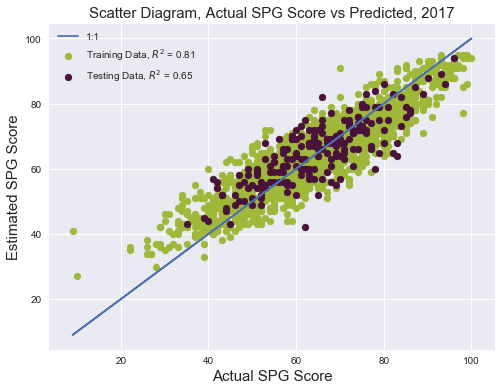

In [14]:
for key, value in subYears.items(): 
    model_xgb_spg(value[0], value[1], key, 'sub')


 ********** 2014 **********
MAE:  6.9797979798
MSE:  78.0202020202
R Squared:  0.48

 ********** 2015 **********
MAE:  6.85279187817
MSE:  74.8223350254
R Squared:  0.48

 ********** 2016 **********
MAE:  6.26395939086
MSE:  61.7868020305
R Squared:  0.51

 ********** 2017 **********
MAE:  6.28426395939
MSE:  62.7512690355
R Squared:  0.55


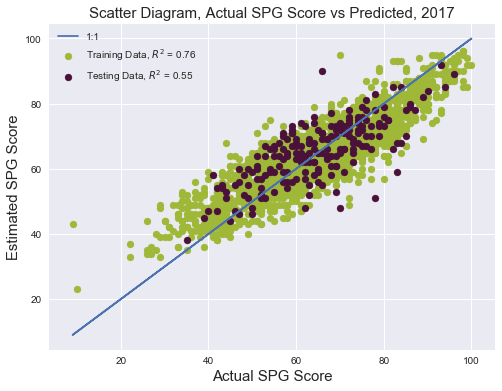

In [15]:
for key, value in impYears.items(): 
    model_xgb_spg(value[0], value[1], key, 'imp')


 ********** 2014 **********
MAE:  5.4595959596
MSE:  50.5303030303
R Squared:  0.66

 ********** 2015 **********
MAE:  5.58375634518
MSE:  52.6395939086
R Squared:  0.64

 ********** 2016 **********
MAE:  5.28426395939
MSE:  46.8274111675
R Squared:  0.63

 ********** 2017 **********
MAE:  4.9847715736
MSE:  39.8781725888
R Squared:  0.72


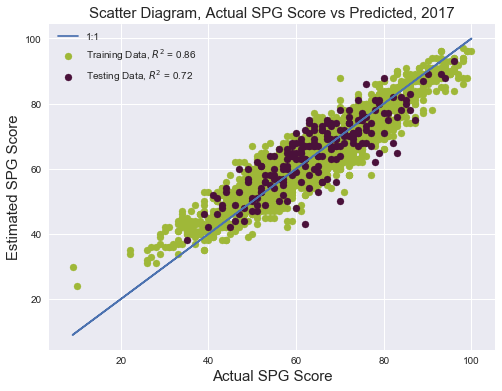

In [16]:
for key, value in allYears.items(): 
    model_xgb_spg(value[0], value[1], key, 'all')

## SVM Regression

In [17]:
# from sklearn.svm import SVR

# def model_svm_spg(X, Y, year, ds):
#     svmReg = SVR(C=0.01, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=True)
#     for train, test in cv_object.split(X, Y): 
#         svmReg.fit(X[train], Y[train])
#         y_trainpred = svmReg.predict(X[train])
#         y_pred = svmReg.predict(X[test])
#         y_trainpred = [round(value) for value in y_trainpred]
#         y_pred = [round(value) for value in y_pred]
#         # evaluate predictions
#     MAE = mean_absolute_error(Y[test], y_pred)
#     MSE = mean_squared_error(Y[test], y_pred)
#     rsq = round(r2_score(Y[test], y_pred),2)
#     rsqtrain = round(r2_score(Y[train], y_trainpred),2)
#     print('\n **********', year,'**********')
#     print('MAE: ', MAE)
#     print('MSE: ', MSE)
#     print('R Squared: ', rsq)
#     if year == '2017': 
#         f, ax = plt.subplots(figsize=(8,6))
#         a= plt.plot(Y[train], Y[train], label = '1:1')
#         b = plt.scatter(Y[train],y_trainpred, color = '#9fb838',
#                         label = ('Training Data, $R^2$ = %G' %rsqtrain))
#         c = plt.scatter(Y[test],y_pred, color = '#4a113a', 
#                         label = ('Testing Data, $R^2$ = %G' %rsq))
#         plt.title('Scatter Diagram, 2017', fontsize = 15)
#         plt.xlabel("Actual SPG Score", fontsize = 15)
#         plt.ylabel("Estimated SPG Score", fontsize = 15)
#         plt.legend()
#         plt.savefig(outPath+'/svm'+ ds +'.png', transparent = True)
#     return MAE, MSE, rsq



In [18]:
# %%time
# model_svm_spg(x_sub_17, y_sub_17, '2017', 'sub')